### Getting a PDF

In [1]:
# Implementing AEGIS.
# Importing necessary packages

import sys
sys.path.append("/home/users/cmo157/DGRB/")
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
import sys
from sbi.inference import SNLE, SNPE, simulate_for_sbi
from sbi import utils 
from sbi import analysis 
from sbi.inference import infer
from getdist import plots, MCSamples
sys.path.append("/home/users/cmo157/DGRB/sources/")
import DMsignal
from scipy.integrate import simpson
from scipy.stats import poisson
import json
sys.path.append("/home/users/cmo157/DGRB/sources/")
import FermiBackgrounds
%matplotlib inline

In [2]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1e3, 1e5] #Mev
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
luminosity_range = 10.0**np.array([30, 37])
max_radius = 8.5+20*2 #kpc
exposure = 2000 * 10 * 1/5 #cm^2 yr 
flux_cut = 1e-9 #photons cm-2 s-1 (minimum flux)
# Cuts are for the creation of sources, not photons, so there is no need to change these. 
angular_cut = np.pi #radians 
angular_cut_gen = angular_cut
lat_cut = 0 #radians 
lat_cut_gen = lat_cut

# Creating the AEGIS object
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen, angular_cut_gen, lat_cut_gen, verbose = False)

In [3]:
# Generating DM Signal
# File path on server 
file_path_DM = "/home/users/cmo157/DGRB/data/dm_spectra/"
channel = "Tau"

My_DM = DMsignal.DMsignal(file_path_DM, channel)

# This is needed as an itialization 
DM_default_model = My_DM.get_default_model()

My_DM.set_spectrum_interpolator(My_DM.channel, mass_MeV=DM_default_model["mass_DM_MeV"])

desired_E = np.linspace(*energy_range, num=1001)

DM_spectrum = My_DM.get_dNdE(desired_E_MeV=desired_E, channel=My_DM.channel, mass_MeV=My_DM.mass_MeV)


In [4]:
# Useful constants

A_DM = DM_default_model["A_DM"]
mass_DM = DM_default_model["mass_DM_MeV"] #MeV
sig_v = 3e-26 # cm^3 s-1
beta = 1.9
A = 1.2e4 # M0-1 kpc-3
rs = 21 # kpc
r0 = 8.5 # kpc
Phi_PP = A_DM * sig_v * simpson(DM_spectrum, x=desired_E) / (8*np.pi * (mass_DM/1000)**2)
print(f"Phi_PP value: {Phi_PP}")
min_mass = 1 #M0


1.3980671735832397e-29


In [5]:
def RL_function(r, L):
    # d2N / dLdV used to implement AEGIS
    # Making sure L and r are floats, and that no r<= 0 
    L = np.asarray(L, dtype=float)
    r = np.asarray(r, dtype=float)
    r = np.clip(r, 1e-12, None)

    # Same shape 
    Lb, rb = np.broadcast_arrays(L, r)

    out = np.empty_like(Lb, dtype=float)
    
    # This is more efficent that doing multiple 'for' loops 
    it = np.nditer([Lb, rb, out], op_flags=[['readonly'], ['readonly'], ['writeonly']])

    for Li, ri, oi in it:

        Li = float(Li); ri = float(ri)
        L_tilde = Li / A_DM

        delta = np.log(Li) - 77.4 + 0.23*np.log(ri / 50) - np.log(8*np.pi*Phi_PP * 1e28)

        sigma = 0.74 + 0.011*np.log(ri / 50)

        mu = sigma**2 * ((1 - beta)/0.87) + delta

        m_scaled_min = 0.87*np.log(min_mass / 10**5)
        m_max = mu + 100*sigma
        m_values = np.linspace(m_scaled_min, m_max, 201)
        
        integral_int = np.exp(- (m_values - mu)**2 / (2*sigma**2))
        integral = simpson(integral_int, x=m_values)

        r_tilde = ri/21
        prefactor = 10**(5*(1-beta)) * A / (0.87 * Li * r_tilde * (1 + r_tilde)**2)
        exponent = np.exp((mu**2 - delta**2) / (2 * sigma**2)) / (np.sqrt(2.0 * np.pi) * sigma)
        val = prefactor*exponent*integral
        oi[...] = max(val, 0.0)
    return out


def RL_40deg(x, L, params):
    # Here x is the distance along the line of sight, as that is what is needed in AEGIS 
    x = np.asarray(x, dtype=float)

    # This converts x into distance from GC 
    r = np.sqrt(x**2 + r0**2 - 2 * x * r0 * np.cos(40*np.pi / 180))
    return RL_function(r, L)

def spectrum(energy, params):
    return My_DM.get_dNdE(desired_E_MeV=energy, channel=My_DM.channel, mass_MeV=My_DM.mass_MeV)

In [6]:
# In order to run these in parallel, a function must first be made which will run for each realization
# Also note that since AEGIS objects may not be picklable we need to create new objects in the function 

def run_single_realisation(run_id, input_params, grains, epsilon):
    # Unique seed for each random realization
    np.random.seed(12345 + run_id)

    # Creating a unique argis object
    my_AEGIS_local = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen, angular_cut_gen, lat_cut_gen, verbose = False)

    als = [RL_40deg, spectrum]
    my_AEGIS_local.abun_lum_spec = [als]
    my_AEGIS_local.source_class_list = ['isotropic_faint_single_spectrum']

    sources = my_AEGIS_local.create_sources(
        input_params,
        grains=grains,
        epsilon=epsilon
    )

    # This keeps track of the different realizations 
    print(f"[Run {run_id}] sources: {len(sources['distances'])}")

    photon_info = my_AEGIS_local.generate_photons_from_sources(
        input_params,
        sources
    )

    print(f"[Run {run_id}] photons: {len(photon_info['energies'])}")

    return photon_info

from multiprocessing import Pool, cpu_count



input_params = []
num_runs = 100
# Can only use as many cores as we have available 
n_workers = min(cpu_count(), num_runs)

# Running and putting each instance into a list 
with Pool(processes=n_workers) as pool:
    photon_info = pool.starmap(
        run_single_realisation,
        [
            (i, input_params, int(1e4), 1e-3)
            for i in range(num_runs)
        ]
    )

[Run 66] sources: 96838161
[Run 66] photons: 87938
[Run 86] sources: 96835742
[Run 86] photons: 86552
[Run 77] sources: 96837589
[Run 62] sources: 96824100
[Run 77] photons: 85986
[Run 62] photons: 86164
[Run 10] sources: 96827714
[Run 41] sources: 96832685
[Run 10] photons: 87087
[Run 41] photons: 87560
[Run 17] sources: 96845166
[Run 17] photons: 86727
[Run 81] sources: 96824006
[Run 80] sources: 96835465
[Run 81] photons: 85372
[Run 85] sources: 96831912
[Run 85] photons: 86983
[Run 80] photons: 87450
[Run 50] sources: 96818915
[Run 58] sources: 96830030
[Run 50] photons: 87098
[Run 58] photons: 86967
[Run 56] sources: 96840585
[Run 56] photons: 86247
[Run 42] sources: 96834919
[Run 42] photons: 86372
[Run 38] sources: 96825841
[Run 38] photons: 86296
[Run 34] sources: 96840173
[Run 34] photons: 85890
[Run 33] sources: 96825276
[Run 33] photons: 86649
[Run 39] sources: 96839603
[Run 4] sources: 96842719
[Run 37] sources: 96846806
[Run 39] photons: 85976
[Run 4] photons: 87048
[Run 3

In [9]:
# Constants for the PDF

N_side = 2**6
N_pix = 12*N_side**2
pix_i = np.linspace(0, N_pix-1, N_pix, dtype='int')
center_mask = 0 # We don't care about a mask for this as the PDF is the same everywhere
lat_mask = 0 

# The bins have length of 1 Count 
mincount = 0
maxcount = int(1e3)
N_Ebins = 1
N_countbins = int(1e3 + 1)
Ebinspace = 'log' # Doesn't matter here
countbinspace = 'linear'
Ebins = np.geomspace(my_AEGIS.Emin_mask + 0.1, my_AEGIS.Emax_mask + 0.1, N_Ebins + 1) - 0.1


1.9413612159592144


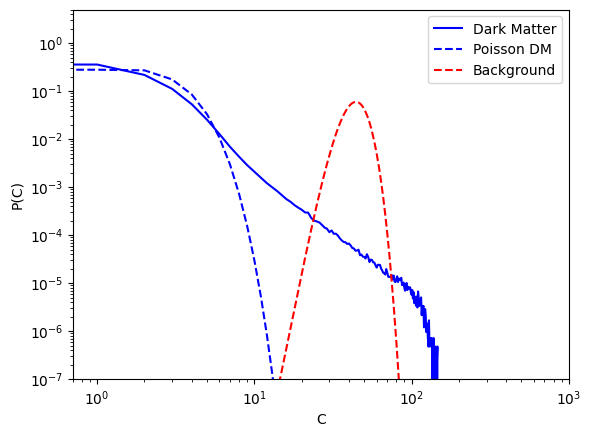

In [10]:
# Will need to have a summary for each realization 
summary = [None] * num_runs

for i in range(0, len(photon_info)):
    roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]
    roi_map = my_AEGIS.get_roi_map_summary(photon_info = photon_info[i], N_side = N_side, N_Ebins = N_Ebins, Ebinspace = Ebinspace, roi_pix_i = roi_pix_i)
    summary[i] = my_AEGIS.get_counts_histogram_from_roi_map(roi_map, mincount = mincount, maxcount = maxcount, N_countbins = N_countbins, countbinspace = countbinspace)

# Adding all the realizations for each count bin 
summary_full = np.sum(summary, axis=0)
summary_full = np.reshape(summary_full, newshape=(N_countbins,))
counts = np.linspace(0, 1e3, int(1e3 + 1))
# Normalize to create a PDF 
norm = simpson(summary_full, x=counts) 
summary_full /= norm

# Creating a Poisson distribution to compare 
mean_DM = sum(x * p for x, p in zip(counts, summary_full))
poisson_DM = poisson.pmf(counts, mean_DM)

# Creating a Background PDF 
file_path = "/home/users/cmo157/DGRB"

My_Background = FermiBackgrounds.FermiBackgrounds(file_path)

background_energy, luminosity = My_Background.get_isotropic_background_spectrum()

non_isotropic_background = My_Background.get_nonistropic_background()

galactic_bg = non_isotropic_background["galactic_bg"]
non_iso_energies = non_isotropic_background["energies_MeV"]

# The mask applies for the background data 
plane_cut = 30 #degrees
center_cut = 60 #degrees
background_file = file_path + '/data/FermiData/galactic_bg_healpix_Nside64.pk'

background_flux = My_Background.get_masked_isotropic_flux(background_file, plane_cut, center_cut, 1e3, 100e3) #cm-2 s-1 sr-1
background_N = background_flux*2000*1/5*10*60*60*24*365.25*(np.pi/180)**2 * 0.85 # 2000cm2 10yr (pi/180)^2sr 1/5FOV

### Had to multiply by a "fudge" factor of 0.85 ###

poisson_background = poisson.pmf(counts, background_N)

plt.plot(counts, summary_full, label="Dark Matter", c='b')
plt.plot(counts, poisson_DM, ls='--', c='b', label="Poisson DM")
plt.plot(counts, poisson_background, label = "Background", ls="--", c="r")
plt.xlabel("C")
plt.ylabel("P(C)")
plt.xscale("log")
plt.yscale("log")
plt.ylim(10**-7, 5)
plt.xlim(7*1e-1, 1000)
plt.legend()